In [1]:
import glob
from typing import Dict, List, NamedTuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pyreadr as pr
import pandas as pd
import seaborn as sns

from tools.figure import seurat
import tools.spongy_panda as spd

In [2]:
class Config(NamedTuple):
    labels: List[pd.core.frame.DataFrame] = [
        pd.read_csv(
            v, 
            index_col=0
        ).sort_values("annot") for v in glob.glob("../data/gse165388_annot/*_clusters.csv")
    ]
    save_dir: str = "../out/gse165388/05_seurat_annot"
    fig_kwarg: Dict[str, Union[str, int, float]] = {
        'facecolor': 'white',
        'dpi': 300,
        'bbox_inches': 'tight',
        'pad_inches': 0.05
    }
    save_file: bool = False
    
conf = Config(save_file=True)

In [3]:
feat = [
    # CGE
    "CALB2",
    
    # Excitatory
    "NEUROD6",

    # LGE
    "ISL1", 
    
    # MGE
    "ERBB4",
    
    # Microglia
    "SPP1",
    
    # NPC
    "HES5",
    
    # OPC
    "PDGFRA",
]

In [4]:
l_data = [
    spd.load_mtx(
        filename=file, colidx_json=colidx, from_r=True
    ).loc[:, feat] for file, colidx in zip(
        glob.glob("../data/gse165388_variablefeat/*feat_matrix.mtx"),
        glob.glob("../data/gse165388_variablefeat/*feat_matrix.json")
    )
]

In [5]:
l_umap = [pr.read_r(v)[None] for v in glob.glob("../data/gse165388_annot/*umap.rds")]

In [6]:
l_labels = [[f"{v}: " for v in df.cluster_id] + df.annot for df in conf.labels]

In [7]:
l_center = [df.assign(label=label).groupby("label").median() for df, label in zip(l_umap, l_labels)]

In [8]:
l_id = [v.split("/")[-1].split("feat")[0] for v in glob.glob("../data/gse165388_variablefeat/*feat_matrix.mtx")]

In [9]:
l_id

['gw10', 'gw11', 'gw12', 'gw9']

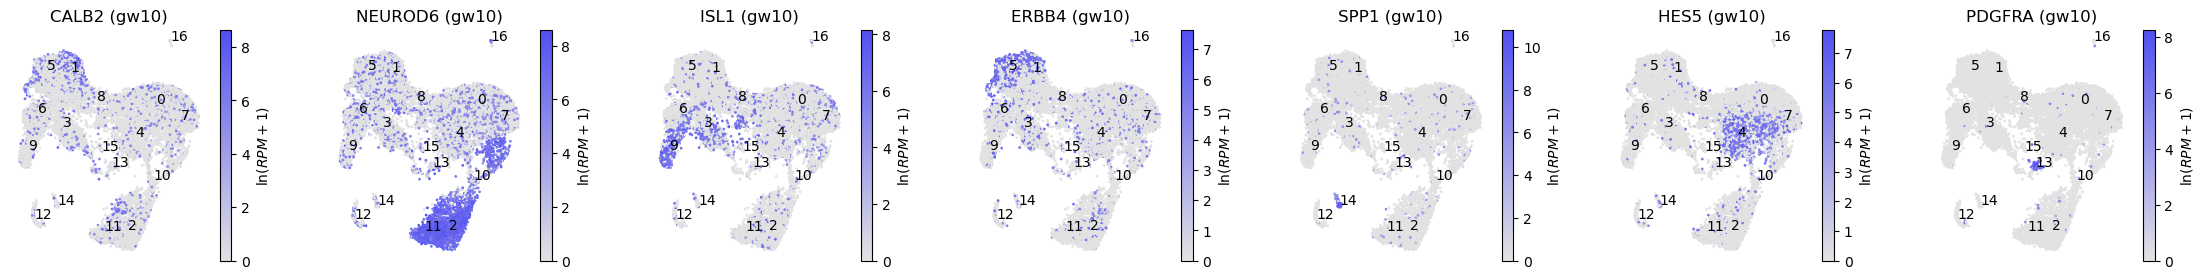

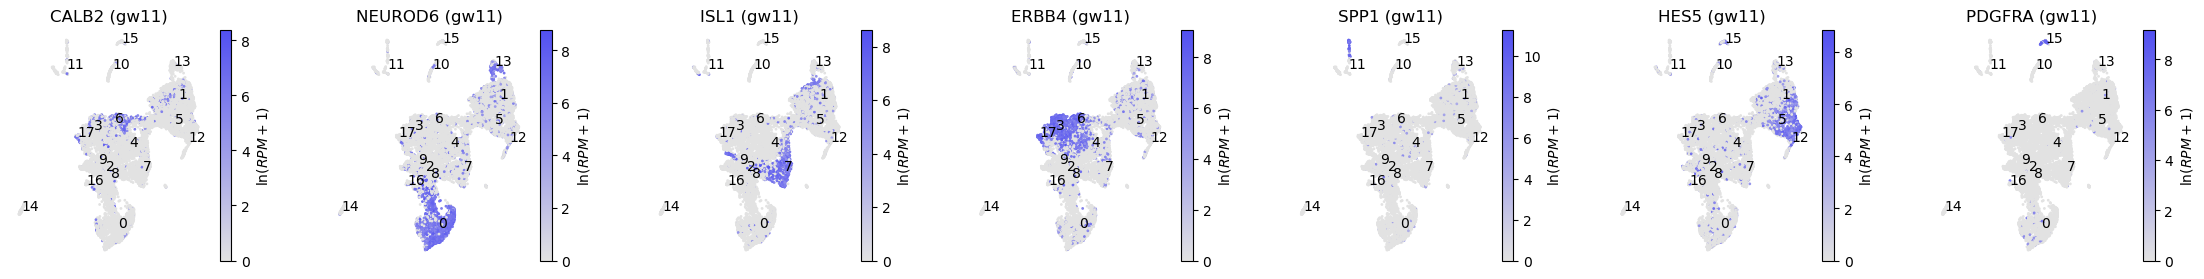

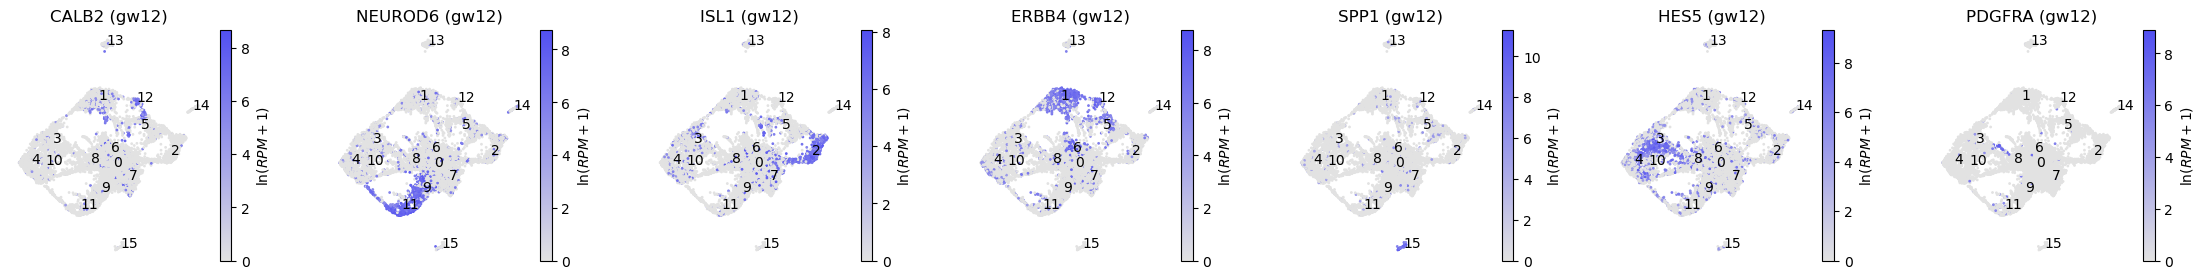

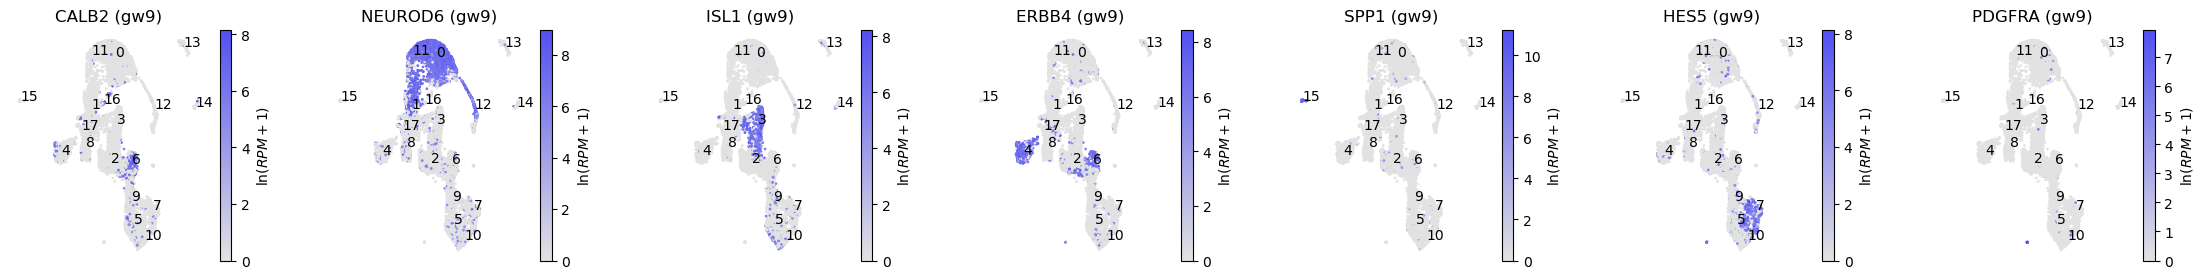

In [10]:
for sample_id, data, coord, center in zip(l_id, l_data, l_umap, l_center):
    
    fig, ax = plt.subplots(1, len(feat), figsize=(4 * len(feat), 3))
    plt.subplots_adjust(wspace=0.3)
    
    for i, gene in enumerate(feat):
        coord.plot.scatter(
            0, 1,
            c=data.to_df().loc[:, gene], cmap=seurat,
            ax=ax[i], s=1
        )
        
        for idx, v in enumerate(center.index):
            ax[i].annotate(v.split(":")[0], center.iloc[idx, :], center.iloc[idx, :])
        
        ax[i].set(title=f"{gene} ({sample_id})")
        ax[i].collections[0].colorbar.set_label("$\ln(RPM+1)$");
        ax[i].axis("off")
    
    if conf.save_file:
        plt.savefig(f"{conf.save_dir}/{sample_id}_markers.png", **conf.fig_kwarg)